# Advanced Data Science - Capstone Project

## Model Training - V.2.0

### Carlos Granados

For this project I decided to use solar power generation data uploaded by [Ani Kannal](https://www.kaggle.com/anikannal "Ani Kannal Profile") in [kaggle.com website](https://www.kaggle.com/anikannal/solar-power-generation-data?select=Plant_1_Generation_Data.csv "Data Set from kaggle"). The idea is to predict the power generation given different weather conditions, as temperature and irradiation, and check the health of the devices.

#### NOTE:
The data sets are ready to be used. We perform here the steps pn ETL, data cleasing and feature engineering in a few cells...

### 0. Install TensorFlow and Keras:

Usually `TensorFlow` and `keras` are not installed by default, so we need to install them first...

In [1]:
!pip install tensorflow==2.2.0

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.2.0-cp36-cp36m-manylinux2010_x86_64.whl (516.2 MB)
  Using cached tensorboard-2.2.2-py3-none-any.whl (3.0 MB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
      Successfully uninstalled tensorflow-estimator-2.1.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.2.0rc0
    Uninstalling tensorflow-2.2.0rc0:
      Successfully uninstalled tensorflow-2.2.0rc0


In [2]:
# On labs.cognitiveclass.ai the V 2.4.3 must be installed
# On IBM Watson it is not necessary to specify
!pip install keras==2.4.3

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!which python3

/opt/intel/intelpython3/bin/python3


### 1. Load Libraries:

In [4]:
# Standard python libraries
import numpy as np
import types
import datetime as dt
from scipy import stats
from numpy.random import seed
from math import ceil

# pandas
import pandas as pd

# Libraries to make plots and related
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.dates import DateFormatter

%matplotlib inline

# For Anomaly Detection, using keras
from keras.layers import Input, Dropout, Dense, LSTM
from keras.models import Model, Sequential, load_model
from keras.callbacks import Callback
#from tensorflow import set_random_seed
import tensorflow as tf

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from joblib import dump, load

# Custom functions, used in this notebook
from ADS_Capstone_model_train_Aux import *

## Others, required by IBM Watson
#import ibm_boto3
#from botocore.client import Config

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


### 2. Re-Read and Check Data Frames

Before to start, lets repeat a couple of steps performed in the *Data Exploration* step.

Some cells are hidden, because they contain sensitive information, as some keys and passwords. The original data files, in CSV format, are already uploaded to IBM Watson project, and they are called from the notebook directly.

#### Note:
When using IBM Watson, the following cells can be (uncommented and) executed in order to read de CSV files directly from the cloud. Otherwise the files must be loaded more "traditionally" (see below)

#### Note:
Execute the following lines when running on cognitiveclass.ai or another platform...

In [32]:
# Path to CSV data files
#path_data = '/resources/Projects/AnomalyDect/SolarPanels/Data/'
path_data = './Data/'

# Read generation data for Plant 1
df_plant1_gen = pd.read_csv(path_data+'Plant_1_Generation_Data.csv')

# Read sensor data for Plant 1
df_plant1_sen = pd.read_csv(path_data+'Plant_1_Weather_Sensor_Data.csv')

In [33]:
# Read generation data for Plant 2
df_plant2_gen = pd.read_csv(path_data+'Plant_2_Generation_Data.csv')

# Read sensor data for Plant 2
df_plant2_sen = pd.read_csv(path_data+'Plant_2_Weather_Sensor_Data.csv')

We create now a huge function that makes all the ETL, data cleasing and feature engineering for us!

In [96]:
# Create DF with all times...
t = np.arange(0, 24, 0.25)
times = []
headers = ['TIME', 'DAY', 'MONTH']

# Add days for May
for day in range(15, 32):
    for i in range(96):
        times.append([t[i], day, 5])

# Add days for June
for day in range(1, 18):
    for i in range(96):
        times.append([t[i], day, 6])
        
times = np.array(times)
df_times = pd.DataFrame(data=times, columns=headers)

Let's extract the 7 first sources for the plant 1. The function `dataProcess` is defined in the corresponding helper file.

In [97]:
df1_all = dataProcess(df_plant1_gen, df_plant1_sen, df_times, 7, nDay=10, nMonth=5)

Extracting data for Source Key : bvBOhCH3iADSZry
Extracting data for Source Key : 1BY6WEcLGh8j5v7
Extracting data for Source Key : VHMLBKoKgIrUVDU
Extracting data for Source Key : 7JYdWkrLSPkdwr4
Extracting data for Source Key : ih0vzX44oOqAx2f
Extracting data for Source Key : ZnxXDlPa8U1GXgE
Extracting data for Source Key : z9Y9gH1T5YWrNuG


In [98]:
df1_all[0].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.0,16.0,16.0
mean,1.875000,15.0,5.0,24.905363,23.173387,0.0,0.0,0.0
std,1.190238,0.0,0.0,0.173963,0.789690,0.0,0.0,0.0
min,0.000000,15.0,5.0,24.536092,21.968571,0.0,0.0,0.0
25%,0.937500,15.0,5.0,24.866299,22.534442,0.0,0.0,0.0
50%,1.875000,15.0,5.0,24.937331,23.093516,0.0,0.0,0.0
75%,2.812500,15.0,5.0,25.006924,23.792217,0.0,0.0,0.0
max,3.750000,15.0,5.0,25.184316,24.384136,0.0,0.0,0.0


In [99]:
df1_all[5].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.0,16.0,16.0
mean,21.875000,15.0,5.0,18.120543,16.840209,0.0,0.0,0.0
std,1.190238,0.0,0.0,8.996340,8.358910,0.0,0.0,0.0
min,20.000000,15.0,5.0,0.000000,0.000000,0.0,0.0,0.0
25%,20.937500,15.0,5.0,22.052180,20.307285,0.0,0.0,0.0
50%,21.875000,15.0,5.0,22.158915,20.691727,0.0,0.0,0.0
75%,22.812500,15.0,5.0,22.236221,20.846315,0.0,0.0,0.0
max,23.750000,15.0,5.0,23.412097,21.241317,0.0,0.0,0.0


In [100]:
len(df1_all)

462

And for the 7 first sources for the plant 2:

In [101]:
df2_all = dataProcess(df_plant2_gen, df_plant2_sen, df_times, 7)

Extracting data for Source Key : V94E5Ben1TlhnDV
Extracting data for Source Key : 81aHJ1q11NBPMrL
Extracting data for Source Key : 9kRcWv60rDACzjR
Extracting data for Source Key : rrq4fwE8jgrTyWY
Extracting data for Source Key : LlT2YUhhzqhg5Sw
Extracting data for Source Key : PeE6FRyGXUgsRhN
Extracting data for Source Key : vOuJvMaM2sgwLmb


In [102]:
df2_all[0].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.0,16.0,16.0
mean,1.875000,15.0,5.0,26.427804,24.734483,0.0,0.0,0.0
std,1.190238,0.0,0.0,0.273325,0.311269,0.0,0.0,0.0
min,0.000000,15.0,5.0,26.001304,24.420678,0.0,0.0,0.0
25%,0.937500,15.0,5.0,26.251819,24.487125,0.0,0.0,0.0
50%,1.875000,15.0,5.0,26.411178,24.601507,0.0,0.0,0.0
75%,2.812500,15.0,5.0,26.533592,25.061857,0.0,0.0,0.0
max,3.750000,15.0,5.0,27.004764,25.317970,0.0,0.0,0.0


In [103]:
df2_all[5].describe()

,TIME,DAY,MONTH,AMB_TEMP,MOD_TEMP,IRRADIATION,AC_POWER,DC_POWER
count,16.000000,16.0,16.0,16.000000,16.000000,16.000000,16.0,16.0
mean,21.875000,15.0,5.0,27.125224,25.519453,0.000008,0.0,0.0
std,1.190238,0.0,0.0,7.373565,6.913076,0.000030,0.0,0.0
min,20.000000,15.0,5.0,0.000000,0.000000,0.000000,0.0,0.0
25%,20.937500,15.0,5.0,28.036519,26.724825,0.000000,0.0,0.0
50%,21.875000,15.0,5.0,28.327012,26.979099,0.000000,0.0,0.0
75%,22.812500,15.0,5.0,30.143441,27.641753,0.000000,0.0,0.0
max,23.750000,15.0,5.0,31.447316,29.370690,0.000120,0.0,0.0


In [42]:
len(df2_all)

1428

### 3. Model Definition

In the model definition phase we explored different deep learning models, and the one that had the best behavior were a sequential one, with several layers. Here we will use such model.

The FFT of the data is not considered, since several of the time parameters (such as time and day and month) are needed to build up the model.

#### 3.1 Auxiliary Functions Definition

We start defining the functions to reshape and normalize the data, and to obtain the losses and plot them.

We use here a custom scaler, since we want to watch closer the variations on the AC/DC power.

**Note:** The `class customNorm` and the `create_trimmed_data_norm` are defined in the corresponding helper file

We modify the `Callback` object in order to save the losses and the calculated accuracy

In [141]:
losses = []

def handleLoss(loss):
    global losses
    losses += [loss]
    #print(loss)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        handleLoss(logs.get('loss'))

And finally we define a function to plot all the obtained losses...

**NOTE:** The functions `plotLoss` and `distLoss` are defined in the helper file...

#### 3.2 Training and Model Functions:

We define also a training function and the MODEL to use. The `trainModel` function, used to train any model, is defined in the corresponding helper file.

And the model:

In [144]:
def anomalyModel3(time_steps, dim, actFun, nLayers=10, nNeurons=50):
    """
    Function to define a neural network, to be used
    in the anomaly detection on the power output generated
    by a solar power plant
    timesteps, dim : (int), to define the shape of the data
    actFun         : (str), activation function
    nLayers        : (int), number of hidden layers
    nNeurons       : (int), number of neurons on each hidden layer
    """
    shape = (time_steps, dim)
    model = Sequential()
    # Input layer
    model.add(Input(shape=shape))
    # Hidden layers
    for i in range(nLayers):
        model.add(LSTM(units=nNeurons, activation=actFun, return_sequences=True))
        #input_shape=shape, 
    #model.add(LSTM(units=nNeurons, input_shape=shape, activation=actFun))
    # Output layer
    model.add(Dense(dim))
    return model

### 4. Deep Learning Model Training

We move now to start the model training. In the model definition we saw that the best performance were obtained using the `MSE` loss function and the `Adam` optimizer.

We will start defining a model with 10 deep layers, with a time step of size 16 (equivalent to the observations performed during 4 hours) and a batch size of 72.

First, the training parameters:

In [155]:
# Training parameters:
timesteps = 16       # Equivalent to obtained observations in a 4 hour period
dim = 8              # Number of considered parameters
batch_size = 4      # 40, 44, 68, 76 or 88, with small osc. in the loss...
epochs = 50
nLoops = 20

nNeurons = 20
nLayers = 20

# Functions used to define the deep learning model:
optFun = 'adam'
lossFun = 'mse'
actFun = 'tanh'

And then the training for the data of the panel 1:

In [156]:
# We initialize the normalizer class
scaler1 = customNorm(df_plant1_gen, df_plant1_sen)

# Data 1st sensor, to start training

init = 1
model1 = None
lossHistory = None
lossAll_m1 = []
for i in df1_all:
    print('df : {}\n----------'.format(i))
    df = df1_all[i]
    [model1, lossVals] = trainModel(df, model1, lossHistory, epochs, lossFun,
                                    optFun, actFun, batch_size=batch_size,
                                    time_steps=timesteps, scaler=scaler1,
                                    dataTrimming=create_trimmed_data_norm,
                                    testModel=anomalyModel3, nLayers=nLayers,
                                    nNeurons=nNeurons, nLoops=nLoops, init=init)
    lossAll_m1.extend(lossVals)
    init = 0

df : 0
----------
df : 1
----------
df : 2
----------
df : 3
----------
df : 4
----------
df : 5
----------
df : 6
----------
df : 7
----------
df : 8
----------
df : 9
----------
df : 10
----------
df : 11
----------
df : 12
----------
df : 13
----------
df : 14
----------
df : 15
----------
df : 16
----------
df : 17
----------
df : 18
----------
df : 19
----------
df : 20
----------
df : 21
----------
df : 22
----------
df : 23
----------
df : 24
----------
df : 25
----------
df : 26
----------
df : 27
----------
df : 28
----------
df : 29
----------
df : 30
----------
df : 31
----------
df : 32
----------
df : 33
----------
df : 34
----------
df : 35
----------
df : 36
----------
df : 37
----------
df : 38
----------
df : 39
----------
df : 40
----------
df : 41
----------
df : 42
----------
df : 43
----------
df : 44
----------
df : 45
----------
df : 46
----------
df : 47
----------
df : 48
----------
df : 49
----------
df : 50
----------
df : 51
----------
df : 52
----------
df 

df : 416
----------
df : 417
----------
df : 418
----------
df : 419
----------
df : 420
----------
df : 421
----------
df : 422
----------
df : 423
----------
df : 424
----------
df : 425
----------
df : 426
----------
df : 427
----------
df : 428
----------
df : 429
----------
df : 430
----------
df : 431
----------
df : 432
----------
df : 433
----------
df : 434
----------
df : 435
----------
df : 436
----------
df : 437
----------
df : 438
----------
df : 439
----------
df : 440
----------
df : 441
----------
df : 442
----------
df : 443
----------
df : 444
----------
df : 445
----------
df : 446
----------
df : 447
----------
df : 448
----------
df : 449
----------
df : 450
----------
df : 451
----------
df : 452
----------
df : 453
----------
df : 454
----------
df : 455
----------
df : 456
----------
df : 457
----------
df : 458
----------
df : 459
----------
df : 460
----------
df : 461
----------


Check the summary:

In [157]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 20)            2320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16, 20)            3280      
_________________________________________________________________
lstm_6 (LSTM)                (None, 16, 20)            3

We check now the losses:

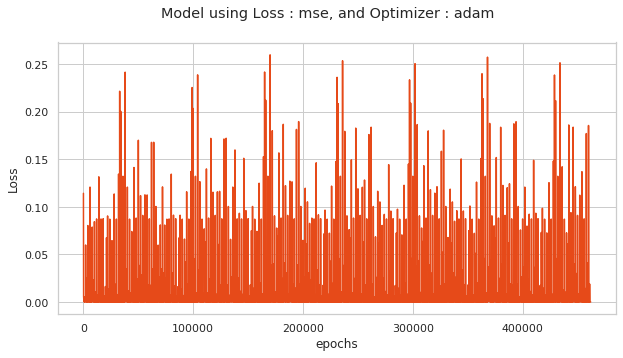

In [158]:
# Normal linear plot

plotLoss(lossAll_m1, lossFun, optFun)

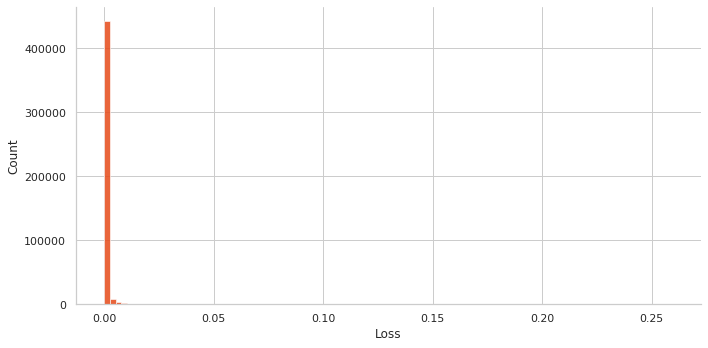

In [159]:
# Distribution plot

distLoss(lossAll_m1, lossFun, optFun, bins=100)

We save the model, in order to use it later:

In [160]:
model1.save('./models/ADS_Capstone.solar_panel_1.model.h5')
print("Model saved")

Model saved


And the training for the panel 2:

In [221]:
init = 1
model2 = None
lossHistory = None
lossAll_m2 = []
for i, df in enumerate(df2_all):
    print('df : {}\n----------'.format(i))
    [model2, lossVals_m2] = trainModel(df, model2, lossHistory, epochs, lossFun, optFun, actFun,
                                    batch_size=batch_size, time_steps=timesteps,
                                    dataTrimming=create_trimmed_data_norm,
                                    testModel=anomalyModel3, nLoops=nLoops,
                                    init=init)
    lossAll_m2.extend(lossVals)
    init = 0

df : 0
----------
df : 1
----------
df : 2
----------


KeyboardInterrupt: 

In [ ]:
model2.summary()

We check the losses

In [ ]:
plotLoss(lossAll_m2, lossFun, optFun)

In [ ]:
distLoss(lossAll, lossFun, optFun)

Finally, we save the model for the 2nd solar panel

In [ ]:
model2.save('./models/ADS_Capstone.solar_panel_2.model.h5')
print("Model saved")

### 5. Machine Learning Training 

As a final part of the model training, we use now the machine learning model, defined by a linear regression, using polynomial features.

In the model definition we find that polynomials of degree 3 perform relatively well...

In [132]:
def trainPoly(df_all, nPoly=3):
    """
    Function to evaluate linear regression with polynomial features
    df_all : (dict of DF), dataframe containing all the data to be
            used to train the model
    nPoly  : (int) Polynomial degree. 3 by default.
    """
    # Name of the columns to be used in the model
    cols_x = ['TIME', 'DAY', 'MONTH', 'MOD_TEMP', 'AMB_TEMP', 'IRRADIATION']
    cols_y = ['DC_POWER']
    # Scaler and methods to be used in the pipeline
    sl = StandardScaler()
    pr = PolynomialFeatures(degree=nPoly, include_bias=False)
    lr = LinearRegression()
    # Definition of the pipeline
    # NOTE: We are not using the scaler, because it was generating
    #       SERIOUS numerical problems!
    print('Initializing pipeline...')
    pipe = Pipeline([ #('scale', sl),
                      ("polynomial_features", pr),
                      ("linear_regression", lr)])
    # Put together all training data in one data frame
    print('Veryfing training data...')
    for i in df_all:
        df = df_all[i].copy(deep=True)
        if i == 0:
            x_train = df[cols_x]
            y_train = df[cols_y]
        else:
            temp_x = df[cols_x]
            temp_y = df[cols_y]
            x_train = pd.concat([x_train, temp_x], ignore_index=True)
            y_train = pd.concat([y_train, temp_y], ignore_index=True)
    # Check number of data points
    x_train.reset_index(inplace=True, drop=True)
    y_train.reset_index(inplace=True, drop=True)
    nx, ny = x_train.shape[0], y_train.shape[0]
    if nx != ny:
        print('WARNING! Number of data points is not equal in X and Y!')
        return None
    else:
        print('{} data points to be used'.format(nx))
        print('Starting training...')
    pipe.fit(x_train, y_train)
    print('Training done!')
    scores = cross_val_score(pipe, x_train, y_train, cv=5)
    yhat = pipe.predict(x_train)
    r2 = r2_score(y_train, yhat)
    print("Accuracy  = {:.2e}(+/- {:.2e})".format(scores.mean(), scores.std()*2))
    print('R-square  = {}\n'.format(pipe.score(x_train, y_train)))
    print('R-sq. Fun = {}\n'.format(r2))
    print('----------------------------------------\n')
    return pipe

We train now a machine learning model, with linear regression and using polynomial features of degree 3, using the data for the solar panel 1:

In [133]:
pipe1 = trainPoly(df1_all)

Initializing pipeline...
Veryfing training data...
7392 data points to be used
Starting training...
Training done!
Accuracy  = 9.85e-01(+/- 7.26e-03)
R-square  = 0.9865910153181828

R-sq. Fun = 0.9865910153181828

----------------------------------------



In [136]:
dump(pipe1, './models/ADS_Capstone.solar_panel_1.ml-deg3.joblib')
print('Model saved')

Model saved


And for the solar panel 2:

In [137]:
pipe2 = trainPoly(df2_all)

Initializing pipeline...
Veryfing training data...
22848 data points to be used
Starting training...
Training done!
Accuracy  = 6.33e-01(+/- 9.34e-02)
R-square  = 0.6602083478322512

R-sq. Fun = 0.6602083478322512

----------------------------------------



In [138]:
dump(pipe2, './models/ADS_Capstone.solar_panel_2.ml-deg3.joblib')
print('Model saved')

Model saved
